In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.visualization.matrix_visualization import cmp_n_mats

from probabilistic_model_synthesis.distributions import SampleLatentsGaussianVariationalPosterior

In [2]:
# ======================================================================================================================
# Parameters for the simulation
# ======================================================================================================================

# Mean and standard deviation of the true prior over regression weights.  (These
# parameters implicitly define the dimensionality of the x-data).

true_beta_mn = torch.tensor([0.0, 1.0, 2.0, 3.0, 4.0], dtype=torch.float32)
true_beta_std = 1*torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32)

# Standard deviation of noise for observations
obs_std = 1

# Number of example systems we generate
n_ex_systems = 100

# Number of samples we observe from each example system
n_smps_per_system = 1

# Number of iterations we run gradient descent for
n_train_its = 1500


In [3]:
# ======================================================================================================================
# Generate data
# ======================================================================================================================

# Generate regression weights for each example system
x_dim = len(true_beta_mn)
true_ex_system_weights = true_beta_mn + true_beta_std*torch.randn(n_ex_systems, x_dim)

#  Generate x and y data for each example system
data = [None]*n_ex_systems
for s_i, beta_i in enumerate(true_ex_system_weights):
    x_i = torch.randn(n_smps_per_system, x_dim)
    expected_output = torch.sum(x_i*beta_i, dim=1)
    y_i = expected_output + obs_std*torch.randn(n_smps_per_system)
    data[s_i] = (x_i, y_i)


In [4]:
# ======================================================================================================================
# Setup everything for synthesis
# ======================================================================================================================

# Initialize CPD - the mean and standard deviation functions are just constant
# since we have no properties to condition on
cpd = CondGaussianDistribution(mn_f=ConstantRealFcn(np.ones([x_dim])),
                               std_f=ConstantBoundedFcn(.01*np.ones([x_dim]),
                                                        10*np.ones([x_dim]),
                                                        3*np.ones([x_dim])))

# Initialize approximate posteriors for each example system
approx_posts = [SampleLatentsGaussianVariationalPosterior(x_dim, 1) for _ in range(n_ex_systems)]


In [5]:
# ======================================================================================================================
# Perform synthesis
# ======================================================================================================================

# Get all parameters
params = list(cpd.parameters()) + list(itertools.chain(*[list(post.parameters()) for post in approx_posts]))

# Setup optimizer
optimizer = torch.optim.Adam(params=params, lr=.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=.1)
# Constant for calculating log-likelihoods
constant = -.5*n_smps_per_system*np.log(2*np.pi*(obs_std**2))

for i in range(n_train_its):

    optimizer.zero_grad()

    # Sample from approximate posteriors over regression weights for each example system
    post_mn_smps = [post.sample([0]) for post in approx_posts]

    # Calculate log-likelihood of observed data conditioned on sampled weights for each example system
    elbo = 0
    for data_i, mn_i in zip(data, post_mn_smps):
        x_i, y_i = data_i
        pred_mn_i = torch.sum(x_i*mn_i, dim=1)
        ll_i = constant - .5 * torch.sum(((y_i - pred_mn_i) / obs_std) ** 2)
        elbo += ll_i

    # Calculate KL divergence between each approximate posterior and cpd
    cpd_mn = cpd(torch.zeros(1)).squeeze()
    cpd_var = cpd.std_f(torch.zeros(1)).squeeze()**2
    for post in approx_posts:
        elbo -= post.kl_btw_diagonal_normal([0], cpd_mn, cpd_var)

    neg_elbo = -1 * elbo
    neg_elbo.backward()
    optimizer.step()

    if i % 100 == 0:
        print('It: ' + str(i) + ', ELBO: ' + str(elbo.item()))

    scheduler.step()


It: 0, ELBO: -2363.326416015625
It: 100, ELBO: -336.5582580566406
It: 200, ELBO: -324.5439758300781
It: 300, ELBO: -446.1349182128906
It: 400, ELBO: -329.6919860839844
It: 500, ELBO: -393.2387390136719
It: 600, ELBO: -251.88150024414062
It: 700, ELBO: -243.50091552734375
It: 800, ELBO: -250.56686401367188
It: 900, ELBO: -235.27903747558594
It: 1000, ELBO: -247.50582885742188
It: 1100, ELBO: -237.8893585205078
It: 1200, ELBO: -235.58811950683594
It: 1300, ELBO: -236.4176025390625
It: 1400, ELBO: -239.59945678710938


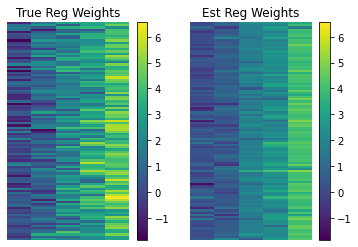

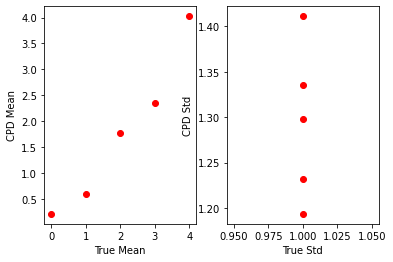

In [6]:
# ======================================================================================================================
# Examine results
# ======================================================================================================================

# Examine posterior means over regression weights compared to true regression weights
est_ex_system_weights = np.stack([post.mns.detach().squeeze().numpy() for post in approx_posts])

plt.figure()
cmp_n_mats([true_ex_system_weights, est_ex_system_weights], show_colorbars=True,
           titles=['True Reg Weights', 'Est Reg Weights'])
plt.draw()

# Examine true mean and standard deviations of prior compared to those of the CPD
cpd_mn = cpd(torch.ones(1)).detach().squeeze().numpy()
cpd_std = cpd.std_f(torch.ones(1)).detach().squeeze().numpy()

plt.figure()
plt.subplot(1,2,1)
plt.plot(true_beta_mn, cpd_mn, 'ro')
plt.xlabel('True Mean')
plt.ylabel('CPD Mean')

plt.subplot(1,2,2)
plt.plot(true_beta_std, cpd_std, 'ro')
plt.xlabel('True Std')
plt.ylabel('CPD Std')

plt.show()